# Lecture #12: Logistic Regression and Gradient Descent
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2021

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
from autograd import numpy as np
from autograd import grad
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

## Outline
1. Logistic Regression
2. Gradient Descent
3. Convex Optimization

# Logistic Regression

## Coin-Toss Revisited: Modeling a Bernoulli Variable with Covariates

Let's revisit our model for coin-toss: we'd assumed that the outcomes $Y^{(n)}$ were independently and identically distributed as Bernoulli's, $Y^{(n)} \sim Ber(\theta)$. Today, we will re-examine the ***identical*** part of the modeling assumptions. 

Realistically, the probability of $Y^{(n)} = 1$ depends on variables like force, angle, spin etc. 

Let $\mathbf{X}^{(n)} \in \mathbb{R}^D$ be $D$ number of such measurements of the $n$-th toss. We model the probability of $Y^{(n)} = 1$ as a function of these ***covariates*** $\mathbf{X}^{(n)}$:

$$
Y^{(n)} \sim Ber\left(\mathrm{sigm}\left(f\left(\mathbf{X}^{(n)}; \mathbf{w}\right)\right)\right)
$$

where $\mathbf{w}$ are the parameters of $f$ and $\mathrm{sigm}$ is the sigmoid function $\mathrm{sigm}(z) = \frac{1}{1 + e^{-z}}$. 

**Note:** we need the sigmoid function to transform an arbitrary real number $f\left(\mathbf{X}^{(n)}; \mathbf{w}\right)$ into a probability (i.e. a number in $[0, 1]$).

## The Logistic Regression Model
Given a set of $N$ observations $(\mathbf{x}^{(1)}, y^{(1)}), \ldots, (\mathbf{x}^{(N)}, y^{(N)})$. We assume the following model for the data.  

$$
Y^{(n)} \sim Ber\left(\mathrm{sigm}\left(f\left(\mathbf{X}^{(n)}; \mathbf{w}\right)\right)\right).
$$

This is called the ***logistic regression*** model.

Fitting this model on the data means ***inferring*** the parameters $\mathbf{w}$ that best aligns with the observations. 

Once we have inferred the parameters $\mathbf{w}$, given a new set of covariates $\mathbf{x}^{\text{new}}$, we can **predict** the probability of $\mathbf{Y}^{\text{new}} = 1$ by computing 

$$\mathrm{sigm}\left(f\left(\mathbf{X}^{(n)}; \mathbf{w}\right)\right).$$

For now, we will assume that $f$ is a linear function:

$$
f\left(\mathbf{X}^{(n)}; \mathbf{w}\right) = \mathbf{w}^\top \mathbf{X}^{(n)}.
$$

## The Relationship Between Logistic Regression and Classification

### What Is Classification?
A regression problem is where we predict a **quantitative** outcome $y$ based on some covariates $x$.

   - **Example:** Given the number of room, the number of allowed guests and the neighborhood, predict price of an Airbnb listing.

A ***classification*** problem is a **categorical** outcome $y$ based on some covariates $x$.

   - **Example:** Given the age, education and income level of a loan applicant, predict whether or not the loan application will be approved.
   
### How Do We Classify?

The data for classification consists of a set of tuples $(\mathbf{x}^{(n)}, y^{(n)})$, where $\mathbf{x}^{(n)}\in \mathbb{R}^D$ is a set of predictors/covariates (e.g. age, income etc) for the $n$-th observation and $y^{(n)}$ is the binary label (e.g. did the person receive the loan). The set of observations that are labeled $y=0$ are called class 0 and the set labeled $y=1$ are called class 1.

The goal is learn a function $f(\mathbf{x})$ so that given a new set of covariates $\mathbf{x}$ we can predict the correpsonding label $y$.

Suppose our data has a small number of predictors, by visualizing the data we can intuitively check how easy it is to separate the classes. In the following example, we have two covariates. We scatter plot the covariates (pictured as crosses and bars), we then indicate data belonging to class 1 by visualizing them as blue crosses and those belonging to class 0 as red bars.

<img src="fig/fig0.png" alt="" style="height: 200px;"/>

Ideally, the classes are easily separated by a curve (or surface) in the input space, this curve (or surface) is called the ***decision boundary***.

When the decision boundary is linear (i.e. a line or a plane), it is defined by the equation

$$
\mathbf{w}^\top \mathbf{x} = w_0x_0 + w_1x_1 + \ldots + w_D x_D = 0
$$

where $x_0 = 1$. Often we write $b = w_0x_0$ and we call $b$ the ***bias*** term.

The vector $\mathbf{w}$ allow us to gauge the 'distance' of a point from the decision boundary. That is, the magnitude of the inner product $|\mathbf{w}^\top \mathbf{x}|$ gives us the distance between the point $\mathbf{x}$ and the decision boundary, whereas the sign of $\mathbf{w}^\top \mathbf{x}$ gives us the side of the decision boundary on which the point $\mathbf{x}$ lies. The proof of this is short and geometric -- you should try to work it out!

*(In the picture below, they use $\mathbf{w}^\top \mathbf{x}$ to express $w_1x_1 + \ldots + w_D x_D + b$, whereas we pretend that $x_0 = 1$ and $b = w_0x_0$. This is just a difference in notation)*
<img src="fig/fig1.png" alt="" style="height: 200px;"/>


Once we have a decision boundary should we always classify points on one side of the boundary as 1 and points on the other side as 0?

<img src="fig/fig2.png" alt="" style="height: 200px;"/>

For classes that are not linearly separable (the classes don't fall cleanly along two sides of a linear decision boundary), we want to make "soft classifications". That is, rather than declaring $y=1$ when $\mathbf{w}^\top \mathbf{x} > 0$ and $y=0$ when $\mathbf{w}^\top \mathbf{x} <0$, we want to encode uncertainty in our prediction of the label $y$. We want to say the following:

> When $\mathbf{x}$ is very far from the decision boundary, i.e. when $|\mathbf{w}^\top \mathbf{x}|$ is very large, and when $\mathbf{w}^\top \mathbf{x}>0$ then we want to say $y=1$ with **high probability** (analogously, when $\mathbf{x}$ is very far from the decision boundary and $\mathbf{w}^\top \mathbf{x}<0$, we want to say $y=0$ with high probability). When $\mathbf{x}$ is very close from the decision boundary, i.e. when $|\mathbf{w}^\top \mathbf{x}|\approx 0$, we want to be maximally uncertain about how predict $y$, i.e. we predict $y$ randomly by a 50-50 chance.

Formalizing this: to model the **probability of labeling a point a certain class**, we have to convert distance, $\mathbf{w}^\top\mathbf{x}$ (which is unbounded) into a number (probability) between 0 and 1, using the ***sigmoid function***:
$$
\text{Prob}(y = 1 | \mathbf{x}) = \text{sigm}(\underbrace{\mathbf{w}^\top\mathbf{x}}_{\text{distance}})
$$
where $\text{sigm}(z) = \frac{1}{1 + e^{-z}}$. This way, when $\mathbf{w}^\top\mathbf{x}$ is large and positive then $\text{sigm}(\underbrace{\mathbf{w}^\top\mathbf{x}}_{\text{distance}})$ is close to 1, when $\mathbf{w}^\top\mathbf{x}$ is large and negative then $\text{sigm}(\underbrace{\mathbf{w}^\top\mathbf{x}}_{\text{distance}})$ is close to 0; when $\mathbf{w}^\top\mathbf{x}$ is near 0 then $\text{sigm}(\underbrace{\mathbf{w}^\top\mathbf{x}}_{\text{distance}})$ is close to 0.5, i.e. $\text{Prob}(y = 1 | \mathbf{x}) = 0.5$. This is exactly what we wanted!

## Interpreting a Logistic Regression Model

Suppose that you fit a logistic regression model to predict whether a loan application should be approved. Suppose that you have three covariates: 

1. `x_1` representing gender: 0 for male, 1 for female
2. `x_2` for the income
3. `x_3` for the loan amount

Suppose that the parameters you found are:
$$
p(y=1 | x_1, x_2, x_3) = \mathrm{sigm}(-1 + 3 x_1 + 1.5 x_2 + 1.75 x_3).
$$

What are the parameters telling us about the most influential attribute for predicting loan approval? What does this say about our data?

## With Great Explanatory Power Comes Great Responsibility!

So in the previous predictve model for loan application model we'd use the follwing covariates:

1. `x_1` representing gender: 0 for male, 1 for female
2. `x_2` for the income
3. `x_3` for the loan amount

We were pleased that using covariates we can hypothesize **why** the outcome $y$ is a certain way - why is the loan approved or denied. But just because we can collect the data for the covariates does it mean that we should use them? It particular, in our logistic model on the previous slide, the most impactful factor on a loan decision was gender, does this seem reasonable? Should we use this model in real-life loan decisions?

In models that are built on human data, covariates containing information that infringes on the rights of the subject to remain anonymous or to keep potentially non-relevant and biasing information out of the decision making process are called **sensitive** or **protected attributes**. 

### When not to use sensitive/protected attributes

Gender, in the case of loan decisions, is a protected attribute, since under the [Equal Credit Opportunity Act](https://www.consumerfinance.gov/fair-lending/) makes it illegal for a creditor to discriminate in any aspect of credit transaction based on certain characteristics including gender. Thus, any decision process using gender to inform a loan decision can be potentially considered discriminatory. 

In fact, most credit models used in industry are trained on data that are stripped of protected attributes - meaning that these models never see covariates like gender during training or deployment!

If we had deployed the logistic model to make real life loan decisions, not only would our decisions be potentially unfair and possibly questionable in terms of financial soundness (since our decisions are heavily influenced by a covariate not directly related to the financial qualifications of a loan applicant), using such a model exposes our company to regulatory sanctions and law-suits. 


### When you might want to use sensitive/protected attributes
 
So should we never collect data on protected attributes? Well, unfortunately, just because we are blind to protected attributes it does not mean that our decisions are fair with respect to these attributes! That is, just because we don't see gender when making decisions, it does not mean that our decisions impact men and women equally. In fact, the Equal Credit Opportunity Act contains explicit language that protects consumers from the [disparate impact](https://www.americanbanker.com/opinion/dont-ditch-disparate-impact) of credit decision systems. Disparate impact is defined as the unequal impact of a credit policy on a legally protected class:

> "A lender's policies, even when applied equally to all its credit applicants, may have a negative effect on certain applicants. For example, a lender may have a policy of not making single family home loans for less than \$60,000. This policy might exclude a high number of applicants who have lower income levels or lower home values than the rest of the applicant pool. That uneven effect of the policy is called disparate impact."

How do modelers and engineers prevent their models from creating disparate impact for protected classes of people? One of the key ways to check for disparate impact is to compare model decisions on protected classes against model decisions against the population (for example, we can compare the percentages of loans the model approves for men and for women). But in order perform these checks, we need access to protected attributes! 

Often times, the models we are auditing for disparate impact are "black-boxes", that is, the inner workings of the model (as well as details like the training procedure) are all proprietary information and we only have access to the models inputs and outputs, $(x_2, x_3, y)$ (note that the black-box model is not using the protected attribute gender $x_1$). In these cases, we can train a proxy model on covariates including protected attributes as well as the predictions of the black-box model, and then analyze our proxy model as an approximation to the black-box model. If we suppose that our logistic regression model in the previous slide was a proxy model that is trained to approximate a black-box model, then our proxy model is telling us that the black-box model's decisions are highly correlated with gender and hence it's decisions may cause disparate impact! This is a case where we needed to look at protected attributes in order to check for regulartory compliance! 

So why is this happening - why is a black-box model that is trained on data stripped of gender information making decisions that are highly correlated with gender? There are many possible explanations for this, but one common reason for this is that gender is a **confounding variable**, that is, some combination of income and loan amount is secretly encoding for gender (e.g. let's say that in your data set, all the men earn 50k-60k and apply for exactly \$10,000 of loans) and the black-box model is ***implicitly*** relying on gender to make loan decisions.



### Appropriate usage of sensitive/protected attributes

So now we see that protected attributes can be extremely useful when we are auditing models for regulatory compliance, should we collect sensitive or protected attributes all the time and as many of them as possible? Unfortunately, it's not so simple: some industries are required by law to collect sensitive attribute data, while others are prohibited from doing so, still others infer sensitive attributes from collected data for compliance checking purposes (e.g. using income and other covariates to infer gender or zip codes to infer race). While useful for antidiscrimnatory purposes, collecting or infering sensitive protected attribute is nonetheless full of challenges and potential pitfalls (for example, protected attributes you infered can violate the subject's right to non-disclosure!) - references in this section addresses the issues of appropriate usage of sensitive attributes. 

Furthermore, **how** you collect and ecnode ata can deeply impact your fairness/compliance analysis. For example, application forms that include two options for gender and three boxes for race may cause us to incorrectly aggregate subjects who do not fall neatly into these boxes under categories that are inappropriate (and by the way, we've not been carefully distinguishing gender and sex in this discussion, but they maybe treated differently under different bodies of laws. Also, are they equivalent concepts to our human subjects from whom we are collecting the data? What are we really trying to measure by collecting gender or sex data?). Such misleading categorization can cause us to miss cases of disparate impact in our analysis, since we have simply missed out on important subgroups of the population. 

If you feel like we're now treading in the unfamiliar territories of social science or law, you are not mistaken! When we work with human data, the interpretation of the data and hence our analysis hinges on our ability to meaningfully understand the data in social contexts and in human terms. Just as we need to consult physicist domain experts when we are building a statistical model for physical data, medical experts when we are building models for medical data, when we build models that have social impact we have to proceed carefully under the advisement of experts on our social/legal systems.


**References for Issues Involving Proper Use of Protected Attributes**
0. <a href="https://journals.sagepub.com/doi/10.1177/0891243215584758">New Categories Are Not Enough: Rethinking the Measurement of Sex and Gender in Social Surveys</a>
1. <a href="https://www.pewsocialtrends.org/2015/11/06/chapter-1-estimates-of-multiracial-adults-and-other-racial-and-ethnic-groups-across-various-question-formats/"> Estimates of Multiracial Adults and Other Racial and Ethnic Groups Across Various Question Formats</a>
2. <a href="https://arxiv.org/pdf/1806.03281.pdf">Blind Justice: Fairness with Encrypted Sensitive Attributes</a>
3. <a href="https://arxiv.org/pdf/1912.06171.pdf">Awareness in Practice: Tensions in Access to Sensitive Attribute Data for Antidiscrimination</a>

## Interpreting a Logistic Regression Model: Log-Odds

A more formal way of interpreting the parameters of the logistic regression model is through the ***log-odds***. That is, we solve for $\mathbf{w}^\top\mathbf{x}$ in terms of $\text{Prob}(y = 1 | \mathbf{x})$.

\begin{aligned}
\text{Prob}(y = 1 | \mathbf{x}) &= \text{sigm}(\mathbf{w}^\top\mathbf{x})\\
\text{sigm}^{-1}(\text{Prob}(y = 1 | \mathbf{x})) &= \mathbf{w}^\top\mathbf{x}\\
\log \left( \frac{\text{Prob}(y = 1 | \mathbf{x})}{1 - \text{Prob}(y = 1 | \mathbf{x})}\right)&= \mathbf{w}^\top\mathbf{x}\\
\log \left( \frac{\text{Prob}(y = 1 | \mathbf{x})}{\text{Prob}(y = 0 | \mathbf{x})}\right)&= \mathbf{w}^\top\mathbf{x}
\end{aligned}
where we used the fact that $\text{sigm}^{-1}(z) = \frac{z}{1 - z}$.

The term $\log \left( \frac{\text{Prob}(y = 1 | \mathbf{x})}{\text{Prob}(y = 0 | \mathbf{x})}\right)$ is essentially a ratio of the probability of $y=1$ and the probability of $y=0$, we can interpret this quantity as the (log) odds of you winning if you'd bet that $y=1$. Thus, we can imagine the parameter $w_d$ for the covariate $x_d$ as telling us if the odd of winning a bet on $y=1$ is good.

1. if $w_d < 0$, then by increasing $x_d$ (while holding all other covariates constant) we make $\mathbf{w}^\top\mathbf{x}$ more negative, and hence the ratio $\frac{\text{Prob}(y = 1 | \mathbf{x})}{\text{Prob}(y = 0 | \mathbf{x})}$ closer to 0. That is, when $w_d < 0$, increasing $x_d$ decreases our odds.<br><br>

2. if $w_d > 0$, then by increasing $x_d$ (while holding all other covariates constant) we make $\mathbf{w}^\top\mathbf{x}$ more positive, and hence the ratio $\frac{\text{Prob}(y = 1 | \mathbf{x})}{\text{Prob}(y = 0 | \mathbf{x})}$ larger. That is, when $w_d > 0$, increasing $x_d$ decreases our odds.

## Maximizing the Logistic Regression Log-likelihood

Given a set of $N$ observations $(\mathbf{x}^{(1)}, y^{(1)}), \ldots, (\mathbf{x}^{(N)}, y^{(N)})$. We want to find $\mathbf{w}_{\text{MLE}}$ that maximizes the log (joint) likelihood:

\begin{aligned}
\small
\mathbf{w}_{\text{MLE}} =& \underset{\mathbf{w}}{\mathrm{argmax}}\;\ell(\mathbf{w}) \equiv \underset{\mathbf{w}}{\mathrm{argmin}}\;-\ell(\mathbf{w}) =\underset{\mathbf{w}}{\mathrm{argmin}}-\log \prod_{n=1}^N p(y^{(n)} | \mathbf{x}^{(n)}) \\
=& \underset{\mathbf{w}}{\mathrm{argmin}}\sum_{n=1}^N -\log\left( \mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)})^{y^{(n)}}(1 -\mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)}))^{1 - y^{(n)}}   \right) \\
=& \underset{\mathbf{w}}{\mathrm{argmin}}\sum_{n=1}^N -y^{(n)}\,\log\,\mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)}) \\
&- (1 - y^{(n)}) \log (1 -\mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)}))
\end{aligned}

Optimizing the likelihood requires us to find the stationary points of the gradient of $\ell(\mathbf{w})$:

$$
\nabla_{\mathbf{w}} \ell(\mathbf{w}) = -\sum_{n=1}^N \left(y^{(n)} - \frac{1}{1 + e^{-\mathbf{w}^\top\mathbf{x}^{(n)}}} \right) \mathbf{x}^{(n)} =\mathbf{0}
$$

Can we solve for $\mathbf{w}$?

# Gradient Descent

## Gradient as Directional Information
The gradient is orthogonal to the level curve of $f$ at $x^*$ and hence, *when it is not zero*, points in the direction of the greatest instantaneous increase in $f$.
<img src="fig/levelcurves.jpg" style="height:300px;">

## An Intuition for Gradient Descent
The intuition behind various flavours of gradient descent  is as follows:

<img src="./fig/fig9.pdf" style='height:400px;'>

## Gradient Descent: the Algorithm
1. start at random place: $\mathbf{w}^{(0)}\leftarrow \textbf{random}$

2. until (stopping condition satisfied):

  a. compute gradient at $\mathbf{w}^{(t)}$: 
     gradient ($\mathbf{w}^{(t)}$) = $\nabla_{\mathbf{w}}$ loss\_function ($\mathbf{w}^{(t)}$)

  b. take a step in the negative gradient direction: 
     $\mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)}$ - $\eta$ * gradient ($\mathbf{w}^{(t)}$)

Here $\eta$ is called the ***learning rate***.

## Diagnosing Design Choices with the Trajectory
If this is your objective function during training, what can you conclude about your step-size?
<img src="./fig/fig13.png" style='height:400px;'>

## Diagnosing Issues with the Trajectory
If this is your objective function during training, what can you conclude about your step-size?
<img src="./fig/fig14.png" style='height:400px;'>

## Diagnosing Issues with the Trajectory
If this is your objective function during training, what can you conclude about your step-size?
<img src="./fig/fig15.png" style='height:400px;'>

## Gradient Descent: Step Size Matters
<img src="./fig/fig10.jpg" style='height:400px;'>

## Gradient Descent for Logistic Regression

When diagnosing our gradient descent learning, we can:

1. Visualize the log-likelihood. **What does this tell us?**
2. Visualize the norm of the gradients. **What does this tell us?**

What else should we visualize to check that our learned model aligns with the data?

In [2]:
# generate 2d classification dataset
centers = [[1, 1], [-1, -1]]
X, y = make_blobs(n_samples=400, n_features=2, centers=centers)
X = np.hstack((X, np.ones((X.shape[0], 1))))

#define the sigmoid function
sigmoid = lambda z: 1. / (1. + np.exp(-z))

#define the negative log-likelihood
nll = lambda X, y, w:  -(y * np.log(sigmoid(X.dot(w))) + (1 - y) * np.log(1 - sigmoid(X.dot(w)))).sum()

#define logistic regression MLE inference by gradient descent
def logistic_regression_fit(X, y, init=None, threshold=1e-6, total_iterations=1000, eta=1e-4):
    #implement the gradient
    gradient = lambda w: -((y - sigmoid(X.dot(w)))[:, np.newaxis] * X).sum(axis=0)
    
    #initialize parameters w
    if init is None:
        init = np.random.normal(0, 1, size=X.shape[1])
    w_current = init
    #store the negative log-likelihood
    nlls = []
    #store the norm of the gradients 
    grad_norms = []
    #initialize the difference between current and new parameters
    delta = 1
    i = 0
    #gradient descent 
    while i < total_iterations and delta > threshold:
        #compute the gradient
        grad = gradient(w_current)
        #update parameter by taking gradient step
        w_next = w_current - eta * grad
        #compute the difference between current parameters and new parameters
        delta = np.linalg.norm(w_next - w_current)
        #compute the norm of the gradient
        grad_norms.append(np.linalg.norm(grad))
        #compute the negative log-likelihood
        nlls.append(nll(X, y, w_current))
        
        w_current = w_next
        i += 1
        
    return w_current, nlls, grad_norms

def plot_diagnostics(ax, nlls, grad_norms):
    ax[0].plot(range(len(nlls)), nlls)
    ax[0].set_title('negative log-likelihood over iterations of gradient descent')
    ax[0].set_ylabel('negative log-likelihood')
    ax[0].set_xlabel('iterations of gradient descent')

    ax[1].plot(range(len(grad_norms)), grad_norms, color='red')
    ax[1].set_title('norms of gradients over iterations of gradient descent')
    ax[1].set_ylabel('norm of gradient')
    ax[1].set_xlabel('iterations of gradient descent')
    return ax

w_MLE, nlls, grad_norms = logistic_regression_fit(X, y, init=None, threshold=1e-6, total_iterations=2000, eta=1e-4)

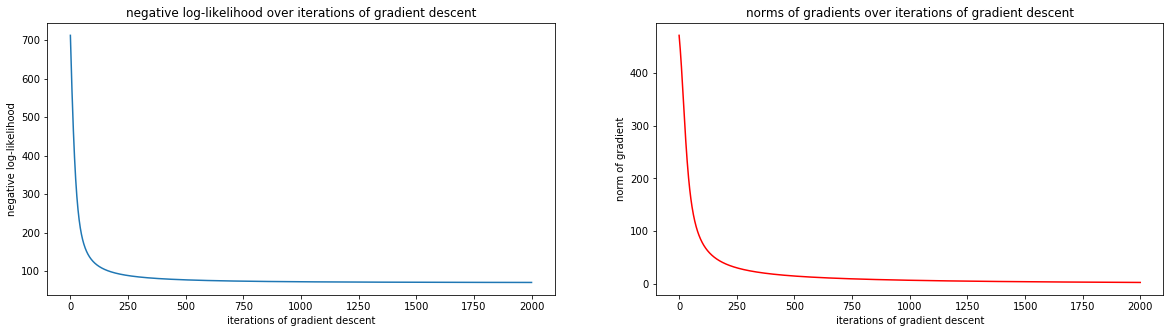

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = plot_diagnostics(ax, nlls, grad_norms)
plt.show()

## But Did We Optimize It?

<img src="fig/optima.jpg" style="height:450px;">

# Convex Optimization

## Convex Sets

A ***convex set*** $S\subset \mathbb{R}^D$ is a set that contains the line segment between any two points in $S$. Formally, if $x, y \in S$ then $S$ contains all convex combinations of $x$ and $y$:

$$
tx + (1-t) y \in S,\quad t\in [0, 1].
$$

<img src="./fig/convexset.jpg" style='height:250px;'>

## Convex Functions
A function $f$ is a ***convex function*** if domain of $f$ is a convex set, and the line segment between the points $(x, f(x))$ and $(y, f(y))$ lie above the graph of $f$. Formally, for any $x, y\in \mathrm{dom}(f)$, we have 

$$
\underbrace{f(tx + (1-t)y)}_{\text{height of graph of $f$ at a point between $x$ and $y$}} \quad \leq \underbrace{tf(x) + (1-t)f(y)}_{\text{height of point on line segment between $(x, f(x))$ and $(y, f(y))$}},\quad t\in [0, 1]
$$


<img src="./fig/convex.jpg" style='height:300px;'>

## Convex Function: First Order Condition

How do we check that a function $f$ is convex? If $f$ is differentiable then $f$ is convex if the graph of $f$ lies above every tangent plane.

**Theorem:** If $f$ is differentiable then $f$ is convex if and only if for every $x \in \mathrm{dom}(f)$, we have

$$
\underbrace{f(y)}_{\text{height of graph of $f$ over $y$}} \geq \underbrace{f(x) + \nabla f(x)^\top (y - x)}_{\text{height of plane tangent to $f$ at $x$, evaluated over $y$}},\quad \forall y\in \mathrm{dom}(f)
$$

<img src="./fig/convex_first_order.jpg" style='height:250px;'>

## Convex Function: Second Order Condition

If $f$ is twice-differentiable then $f$ is convex if the "second derivative is positive".

**Theorem:** If $f$ is twice-differentiable then $f$ is convex if and only if the Hessian $\nabla^2 f(x)$ is positive semi-definite for every $x\in \mathrm{dom}(f)$. 

<img src="./fig/convex_nonconvex.jpg" style='height:300px;'>

## Properties of Convex Functions

How to build complex convex functions from simple convex functions:

1. if $w_1, w_2 \geq 0$ and $f_1, f_2$ are convex, then $h = w_1 f_1 + w_2 f_2$ is convex<br><br>

2. if $f$ and $g$ are convex, and $g$ is univariate and non-decreasing then $h = g \circ f$ is convex<br><br>

3. Log-sum-exp functions are convex: $f(x) = \log \sum_{k=1}^K e^{x}$

**Note:** there are many other convexity preserving operations on functions.


## Convex Optimization

A ***convex optimization problem*** is an optimization of the following form:

\begin{aligned}
\mathrm{min}\; &f(x) & (\text{convex objective function})\\
\text{subject to}\; & h_i(x) \leq 0, i=1, \ldots, i & (\text{convex inequality constraints}) \\
& a_j^\top x - b_j = 0, j=1, \ldots, J & (\text{affine equality constraints}) \\
\end{aligned}

The set of points that satisfy the constraints is called the ***feasible set***.

You can prove that the a convex optimization problem optimizes a convex objective function over a convex feasible set. But why should we care about convex optimization problems?

**Theorem:** Let $f$ be a convex function defined over a convex feasible set $\Omega$. Then if $f$ has a local minimum at $x\in \Omega$ -- $f(y) \geq f(x)$ for $y$ in a small neighbourhood of $x$ -- then $f$ has a global minimum at $x$.

**Corollary:** Let $f$ be a differentiable convex function:
1. if $f$ is unconstrained, then $f$ has a **local minimum** and hence **global minimum** at $x$ if $\nabla f(x) = 0$.
2. if $f$ is constrained by equalities, then $f$ has a global minimum at $x$ if $\nabla J(x, \lambda) = 0$, where $J(x, \lambda)$ is the Lagrangian of the constrained optimization problem.

**Note:** we can also characterize the global minimum of inequalities constrained convex optimization problems using the Lagrangian, but the formulation is more complicated.

## Convexity of the Logistic Regression Negative Log-Likelihood

But why do we care about convex optimization problems? Let's connect the theory of convex optimization to MLE inference for logistic regression. Recall that the negative log-likelihood of the logistic regression model is

\begin{aligned}
-\ell(\mathbf{w}) &= -\sum_{n=1}^N y^{(n)}\,\log\,\mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)}) + (1 - y^{(n)}) \log (1 -\mathrm{sigm}(\mathbf{w}^\top \mathbf{x}^{(n)}))\\
&=\sum_{n=1}^N y^{(n)} \log(e^0 + e^{\mathbf{w}^\top \mathbf{x}^{(n)}}) + (1 - y^{(n)})(- \mathbf{w}^\top \mathbf{x}^{(n)})
\end{aligned}

**Proposition:** The negative log-likelihood of logistic regression $-\ell(\mathbf{w})$ is convex.

**What does this mean for gradient descent?** If gradient descent finds that $\mathbf{w}^*$ is a stationary point of $-\nabla_{\mathbf{w}}\ell(\mathbf{w})$ then $-\ell(\mathbf{w})$ has a global minimum at $\mathbf{w}^*$. Hence, $\ell(\mathbf{w})$ is maximized at $\mathbf{w}^*$.

***Proof of the Proposition:*** Note that
1. $- \mathbf{w}^\top \mathbf{x}^{(n)}$ and $(1 - y^{(n)})(- \mathbf{w}^\top \mathbf{x}^{(n)})$ are convex, since they are linear
2. $\log(e^0 + e^{\mathbf{w}^\top \mathbf{x}^{(n)}})$ is convex since it is the composition of a log-sum-exp function (which is convex) and a convex function $\mathbf{w}^\top \mathbf{x}^{(n)}$
3. $\sum_{n=1}^N y^{(n)} \log(e^0 + e^{\mathbf{w}^\top \mathbf{x}^{(n)}})$ is convex since it is a nonnegative linear combination of convex functions
4. $-\ell(\mathbf{w})$ is convex since it is the sum of two convex functions

## But Does It Always Converge?
We've seen that if we choose the learning rate to be too large (say for example `1e10` then gradient descent can fail to converge even if the function $f$ is convex. But how large is "too large". There are two cases to consider

1. You have some prior knowledge about how smooth the function $f$ is -- i.e. how quickly $f$ can increase or decrease. Then using this you can choose a learning rate that will provably guaratee convergence<br><br>
2. In most cases, the objective function (like the log-likelihood) may be too complex to reason about. In which case, 
  1. we do a scientific "guess-and-check" to determine the learning rate:
    1. we find a learning rate that is large enough to cause gradient descent to diverge
    2. we find a leanring rate that is small enough to cause gradient descent to converge too slowly
    3. we choose a range of values between the large rate and the small rate and try them all to determine the optimal rate<br><br>
  2. alternatively, we can choose the step-size $\eta$ adaptively (e.g. when the gradient is large we can set $\eta$ to be moderate to small and when the gradient is small we can set $\eta$ to be larger). There are a number of adaptive step-size regimes that you may want to look up and implement for your specific problem.
  
The prior knowledge required to choose $\eta$ for provable convergence is called Lipschitz continuity. If we knew that $f$ is convex, differentiable and that there is a constant $L>0$ such that $\|\nabla f(x) - \nabla f(y)\|_2 \leq L\|x -y\|_2$, then if we choose a fixed step size to be $\eta \leq \frac{1}{L}$ then gradient descent **provably** converges to the global minimum of $f$ as the number of iterations $N$ goes to infinity. The constant $L$ is called the ***Lipschitz constant***.

## But How Quickly Can We Get There?

Just because we know gradient descent will converge it doesn't mean that it will give us a good enough approximation of the global minimum within our time limit. This is why studying the ***rate of convergence*** of gradient descent is extremely important. Again there are two cases to consider

1. You have prior knowledge that $f$ is convex, differentiable and its Lipschitz constant is $L$ and suppose that $f$ has a global minimum at $x^*$, then for gradient descent to get within $\epsilon$ of $f(x^*)$, we need $O(1/\epsilon)$ number of iterations.<br><br>

2. In most cases, the objective function will fail to be convex and its Lipschitz constant may be too difficult to compute. In this case, we simply stop the gradient descent when the gradient is sufficiently small.


## But Does It Scale?

Gradient is such a simple algorithm that can be applied to **any optimization problem** for which you can compute the gradient of the objective function. 

**Question:** Does this mean that maximum likelihood inference for statistical models is now an easy task (i.e. just use gradient descent)?

For every likelihood optimization problem, evaluating the gradient at a set of parameters $\mathbf{w}$ requires evaluating the likelihood of the entire dataset using $\mathbf{w}$:

$$
\nabla_{\mathbf{w}} \ell(\mathbf{w}) = -\sum_{n=1}^N \left(y^{(n)} - \frac{1}{1 + e^{-\mathbf{w}^\top\mathbf{x}^{(n)}}} \right) \mathbf{x}^{(n)} =\mathbf{0}
$$

Imagine if the size of your dataset $N$ is in the millions. Naively evaluating the gardient **just once** may take up to seconds or minutes, thus running gradient descent until convergence may be unachievable in practice!

**Idea:** Maybe we don't need to use the entire data set to evaluate the gradient during each step of gradient descent. Maybe we can approximate the gradient at $\mathbf{w}$ well enough with just a subset of the data.